# **Project: 1. Forecasting Monthly Upper Ocean Heat Content**
## **Univariate Time-Series and ARIMA Models**
### **Author:** Seguy Gencoglu


#### **Objective**

The rising ocean heat content (OHC) plays a critical role in climate change, affecting global weather patterns, sea levels, and marine ecosystems. However, understanding and predicting ocean heat fluctuations is essential for preparing for extreme weather events, improving climate models, and guiding global policy decisions.

This project aims to analyze and forecast monthly upper ocean heat content to detect long-term warming trends, identify seasonal variations, and predict future ocean temperature changes. Using ARIMA modeling, I explore how ocean heat levels have evolved over time and how they may change in the coming years.

By applying time series forecasting methods, we can answer key questions:

* Is the ocean heat content increasing at an alarming rate?
* Are there seasonal variations that affect global climate conditions?
* How accurately can we predict future ocean temperatures?
* Can forecasting models provide early warnings for extreme climate events?

Understanding these trends is crucial for climate scientists, policymakers, and environmental agencies to take informed action in mitigating climate change effects.


Data Set is obtained from the Our World in Data's website, which can be found at: https://ourworldindata.org/grapher/monthly-upper-ocean-heat?time=2010-02-15..latest

In [ ]:
#import necessary libraries
import pandas as pd
import numpy as np
import datetime
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
#Ignore some warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


## **1. DATA PREPARATION**

### **1.1 Data Loading and Preprocessing**



In [ ]:
# Load Data
file_path = "sample_data/monthly-upper-ocean-heat.csv"
df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 4 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Entity                                                         179 non-null    object 
 1   Code                                                           179 non-null    object 
 2   Day                                                            179 non-null    object 
 3   Monthly average ocean heat content for the 0-700 meters layer  179 non-null    float64
dtypes: float64(1), object(3)
memory usage: 5.7+ KB


In [ ]:
df.head()

,Entity,Code,Day,Monthly average ocean heat content for the 0-700 meters layer
0,World,OWID_WRL,2010-02-15,9.665913
1,World,OWID_WRL,2010-03-15,10.365477
2,World,OWID_WRL,2010-04-15,7.883140
3,World,OWID_WRL,2010-05-15,7.801555
4,World,OWID_WRL,2010-06-15,10.406611


In [ ]:
# Drop unnecessary columns
df.drop(columns=["Entity", "Code"], inplace=True)

# Rename columns for easier access
df.columns = ["Date", "Ocean_Heat_Content"]

In [ ]:
df.head()

,Date,Ocean_Heat_Content
0,2010-02-15,9.665913
1,2010-03-15,10.365477
2,2010-04-15,7.883140
3,2010-05-15,7.801555
4,2010-06-15,10.406611


In [ ]:
# Check for missing values
print("Missing values before handling:")
print(df.isnull().sum())

Missing values before handling:
Date                  0
Ocean_Heat_Content    0
dtype: int64


In [ ]:
# Convert Date column to datetime format
df["Date"] = pd.to_datetime(df["Date"])


In [ ]:
# Set Date as index
df.set_index("Date", inplace=True)

In [ ]:
# Filter data for the last 10 years
df = df[df.index >= pd.to_datetime("2014-01-01")]

In [ ]:
# Check time intervals
df["delta"] = df.index.to_series().diff()
print("Time intervals between records:")
print(df[["delta"]].head())

Time intervals between records:
             delta
Date              
2014-01-15     NaT
2014-02-15 31 days
2014-03-15 28 days
2014-04-15 31 days
2014-05-15 30 days


<ipython-input-10-796e7e535e1c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["delta"] = df.index.to_series().diff()


The dataset has monthly data and each entry is recorded on the 15th of each month, not at month-end or month-start. Meaning that the intervals are consistent.

In [ ]:
df.drop(columns=["delta"], inplace=True)

<ipython-input-11-005a0bd2b826>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["delta"], inplace=True)


In [ ]:
df.head()

,Ocean_Heat_Content
Date,
2014-01-15,12.459326
2014-02-15,13.192856
2014-03-15,13.091687
2014-04-15,10.961282
2014-05-15,11.422136


### **Check outliers**

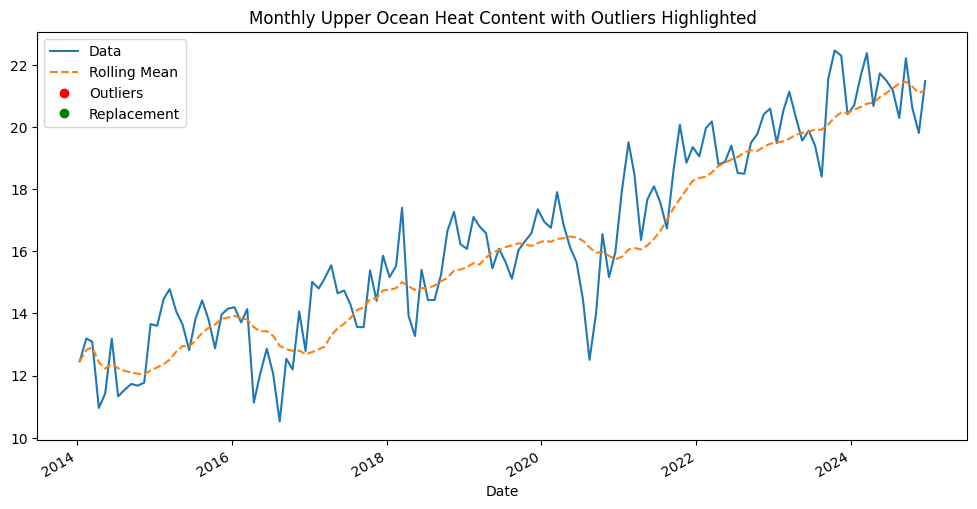

In [ ]:
# Identifies values with a Z-score greater than 3 as outliers
def rolling_zscore(series, window=50):
    avg = series.rolling(window=window, min_periods=1).mean()
    std = series.rolling(window=window, min_periods=1).std()
    z = (series - avg) / std
    mask = abs(z) > 3
    return z, avg, std, mask

# Compute rolling Z-score for detecting outliers: computes a moving average and standard deviation over a 12-month window
z, avg, std, mask = rolling_zscore(df['Ocean_Heat_Content'], window=12)

plt.figure(figsize=(12, 6))
df['Ocean_Heat_Content'].plot(label='Data')
avg.plot(label='Rolling Mean', linestyle='dashed')
df.loc[mask, 'Ocean_Heat_Content'].plot(label='Outliers', marker='o', ls='', color='red') # These are extreme values that deviate significantly from the trend.
avg[mask].plot(label='Replacement', marker='o', ls='', color='green') #  These are the rolling mean values used to replace the outliers, ensuring smooth data
plt.legend()
plt.title("Monthly Upper Ocean Heat Content with Outliers Highlighted")
plt.show()

Based on the Z-score statistical analysis and the graph, the data fluctuates but does not show extreme anomalies. The data appears to follow a smooth increasing trend.








### **1.2 Data Visualization**

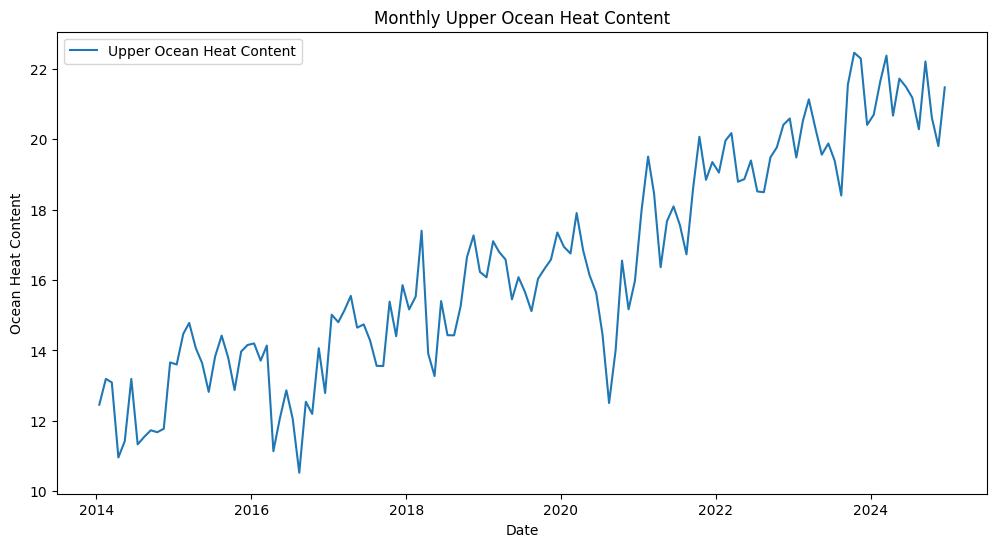

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2014-01-15 to 2024-12-15
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Ocean_Heat_Content  132 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB
None
            Ocean_Heat_Content
Date                          
2014-01-15           12.459326
2014-02-15           13.192856
2014-03-15           13.091687
2014-04-15           10.961282
2014-05-15           11.422136


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df["Ocean_Heat_Content"], label="Upper Ocean Heat Content")
plt.title("Monthly Upper Ocean Heat Content")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Ocean Heat Content")
plt.show()
print(df.info())
print(df.head())

**Interpretation of the graph above:**

The plot shows a clear upward trend in Monthly Upper Ocean Heat Content, indicating that ocean heat content is increasing over time. We can say that the data follows a consistent upward pattern with periodic fluctuations.

Looking at the graph, we see that there is visible long-term warming trend, with ocean heat content increasing significantly from 2014 to 2024. This suggests that the upper ocean is steadily warming over time.

Volatility appears to increase after 2019, with larger fluctuations in ocean heat content.
We can also confirm this from the previous Rolling standard deviation plots.

### **Time Series Decomposition**

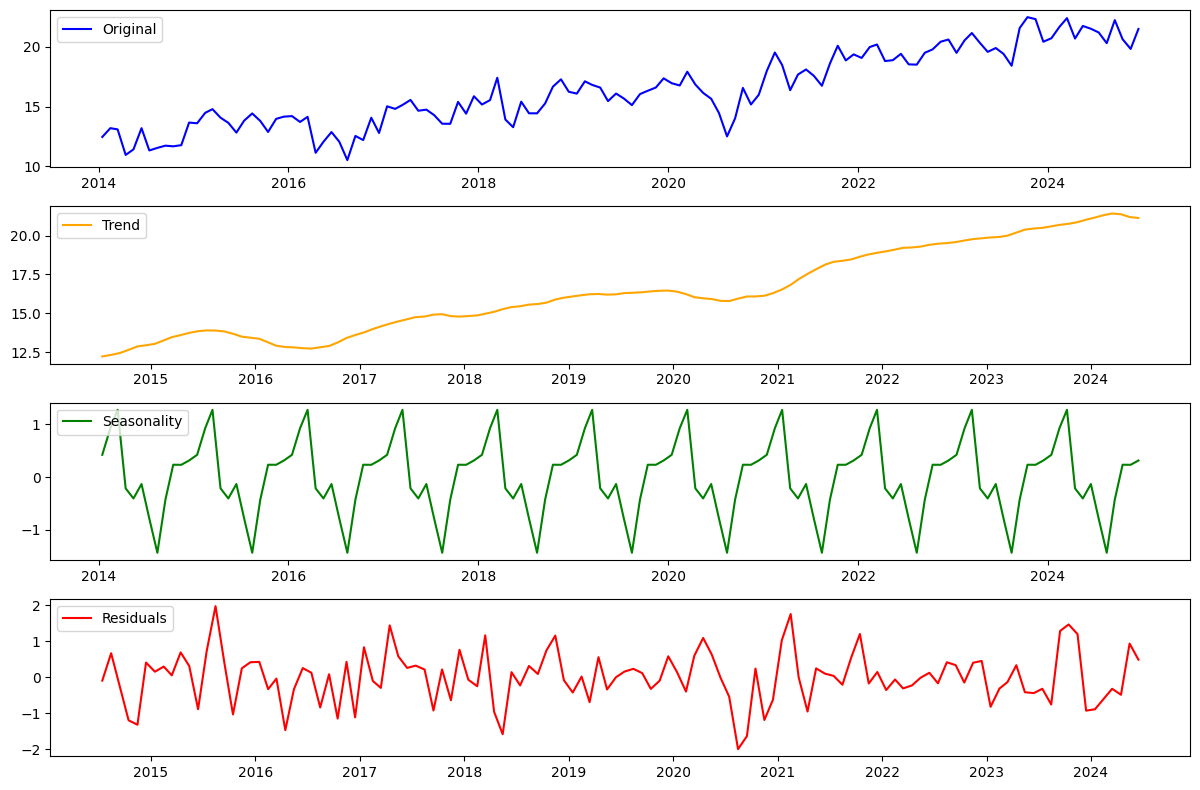

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(df['Ocean_Heat_Content'], model='additive', period=12)

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df['Ocean_Heat_Content'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposed.trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposed.seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposed.resid, label='Residuals', color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


1. The trend component shows a steady increase in ocean heat content over time.
This confirms that the data is potentially non-stationary, and differencing might be needed for ARIMA modeling.
2. The seasonality component shows repeating fluctuations every year.
3. Residuals show noticeable fluctuations, which means we need to apply some methods to investigate such as an ARIMA model might be needed to better handle dependencies.










## **2. Statistical Analysis**

### **2.1 Stationarity Analysis**

#### **ADF Test**

In [ ]:
def check_stationarity(series):
    result = adfuller(series)
    print("ADF Test Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] < 0.05:
        print("The data is stationary (reject null hypothesis).")
    else:
        print("The data is not stationary (fail to reject null hypothesis). Differencing might be needed.")


In [ ]:
# Perform stationarity test
check_stationarity(df['Ocean_Heat_Content'])

ADF Test Statistic: -0.6115166418254279
p-value: 0.8683584453574914
Critical Values: {'1%': -3.484219653271961, '5%': -2.885145235641637, '10%': -2.579359138917794}
The data is not stationary (fail to reject null hypothesis). Differencing might be needed.


#### **Visualizing Rolling Mean & Standard Deviation for Stationarity Check**

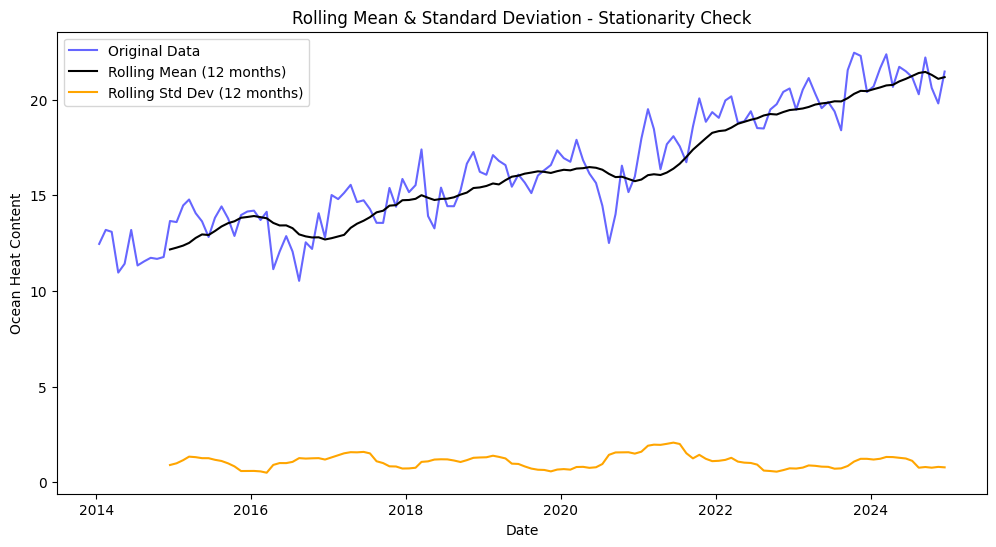

In [ ]:
plt.figure(figsize=(12, 6))

# Compute rolling mean and rolling standard deviation
rolling_mean = df['Ocean_Heat_Content'].rolling(window=12).mean()
rolling_std = df['Ocean_Heat_Content'].rolling(window=12).std()

# Plot the original data
plt.plot(df['Ocean_Heat_Content'], label='Original Data', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean (12 months)', color='black')
plt.plot(rolling_std, label='Rolling Std Dev (12 months)', color='orange')

# Labels and legend
plt.legend()
plt.title("Rolling Mean & Standard Deviation - Stationarity Check")
plt.xlabel("Date")
plt.ylabel("Ocean Heat Content")
plt.show()

By looking at both the plot above and ADF results, we can see that the dataset is not stationary, which means it does not have constant mean and standard deviation.

Since data is not stationary and I want to use a model such as ARIMA, the data has to be transformed.

### **Differencing**

I will perform first differencing to see if it removes the trend of the data. Then do perform ADF test to see if the data in fact became stationary.

In [ ]:
df["Diff_1"] = df["Ocean_Heat_Content"].diff()
adf_diff_1 = adfuller(df["Diff_1"].dropna())

print(f"ADF Test p-value (After First Differencing): {adf_diff_1[1]}")
print("Critical Values:", adf_diff_1[4])

if adf_diff_1[1] < 0.05:
    print("The data is stationary (reject null hypothesis).")
else:
    print("The data is NOT stationary (fail to reject null hypothesis). Further differencing may be needed.")


ADF Test p-value (After First Differencing): 4.1865534590708e-10
Critical Values: {'1%': -3.484219653271961, '5%': -2.885145235641637, '10%': -2.579359138917794}
The data is stationary (reject null hypothesis).


 p-value < 0.05 and The test statistic is lower than all critical values, confirming stationarity. The differenced series is stationary. The first differencing successfully removed the trend.

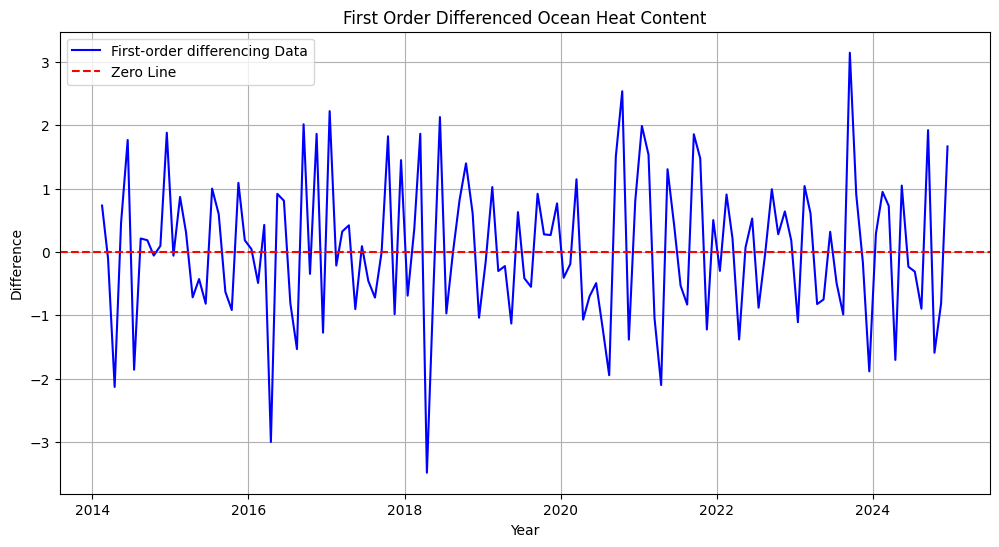

In [ ]:
# Plot First-Order Differenced Series as a Separate Graph
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Diff_1"], label="First-order differencing Data", color='blue')
plt.axhline(y=0, color='red', linestyle='dashed', label="Zero Line")
plt.title("First Order Differenced Ocean Heat Content")
plt.xlabel("Year")
plt.ylabel("Difference")
plt.legend()
plt.grid(True)
plt.show()


The graph above confirms that the differencing process successfully removed the upward trend present in the original time series. The data now fluctuates around zero, indicating a more stationary pattern, with oscillations appearing more stable—suggesting that the variance has been stabilized.

Visually, this suggests a significant improvement in stationarity.

To further validate this, I will generate a plot comparing the rolling mean and standard deviation of the differenced series. This will help confirm whether the data maintains a constant mean and variance, which are key indicators of stationarity.

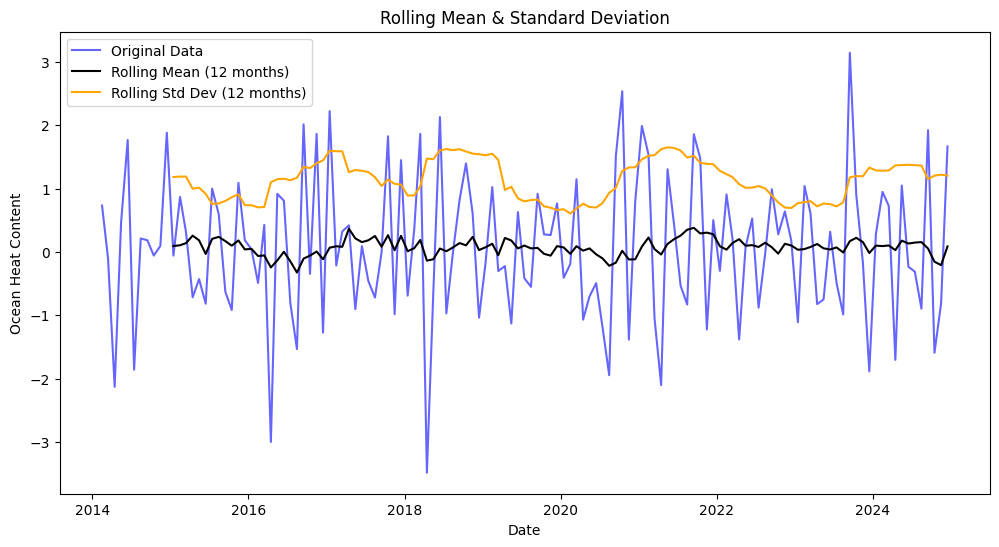

In [ ]:
plt.figure(figsize=(12, 6))

# Compute rolling mean and rolling standard deviation
rolling_mean = df["Diff_1"].rolling(window=12).mean()
rolling_std = df["Diff_1"].rolling(window=12).std()

# Plot the original data
plt.plot(df["Diff_1"], label='Original Data', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean (12 months)', color='black')
plt.plot(rolling_std, label='Rolling Std Dev (12 months)', color='orange')

# Labels and legend
plt.legend()
plt.title("Rolling Mean & Standard Deviation")
plt.xlabel("Date")
plt.ylabel("Ocean Heat Content")
plt.show()

The rolling mean and standard deviation plot confirms that first-order differencing (d=1) successfully removed the trend, as the rolling mean remains relatively stable over time. The rolling standard deviation also shows no significant upward or downward trend, indicating that variance is stable and further transformation is unnecessary. The differenced series fluctuates around zero, reinforcing the improvement in stationarity. However, some noticeable spikes remain, particularly after 2018 and around 2024, which may indicate noise or temporary shocks. Despite these fluctuations, the overall pattern suggests that the data is now ready for ARIMA modeling, with the next step being ACF/PACF analysis to determine the optimal (p, q) parameters for forecasting.

Let's also do again ACF test to verify the stability.


**Verify with ADF test**

In [ ]:
result = adfuller(df["Diff_1"].dropna())
print("ADF Test Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

if result[1] < 0.05:
    print("The data is stationary (reject null hypothesis).")
else:
    print("The data is NOT stationary (fail to reject null hypothesis). Further differencing may be needed.")


ADF Test Statistic: -7.100232078439774
p-value: 4.1865534590708e-10
Critical Values: {'1%': -3.484219653271961, '5%': -2.885145235641637, '10%': -2.579359138917794}
The data is stationary (reject null hypothesis).


From the above ADF Test results, we can confirm that the data is now stationary; p value is way below the standard 0.05 threshold. ADF test statistic is highly negative value, which suggests a strong rejection of the null hypothesis.
No further differencing is needed and I can proceed with ARIMA modeling.

### **Autocorrelation Analysis**

After our time series has been stationarized by differencing, the next step is to take a look at the ACF and PACF plots to determine the number of AR or MA terms needed.

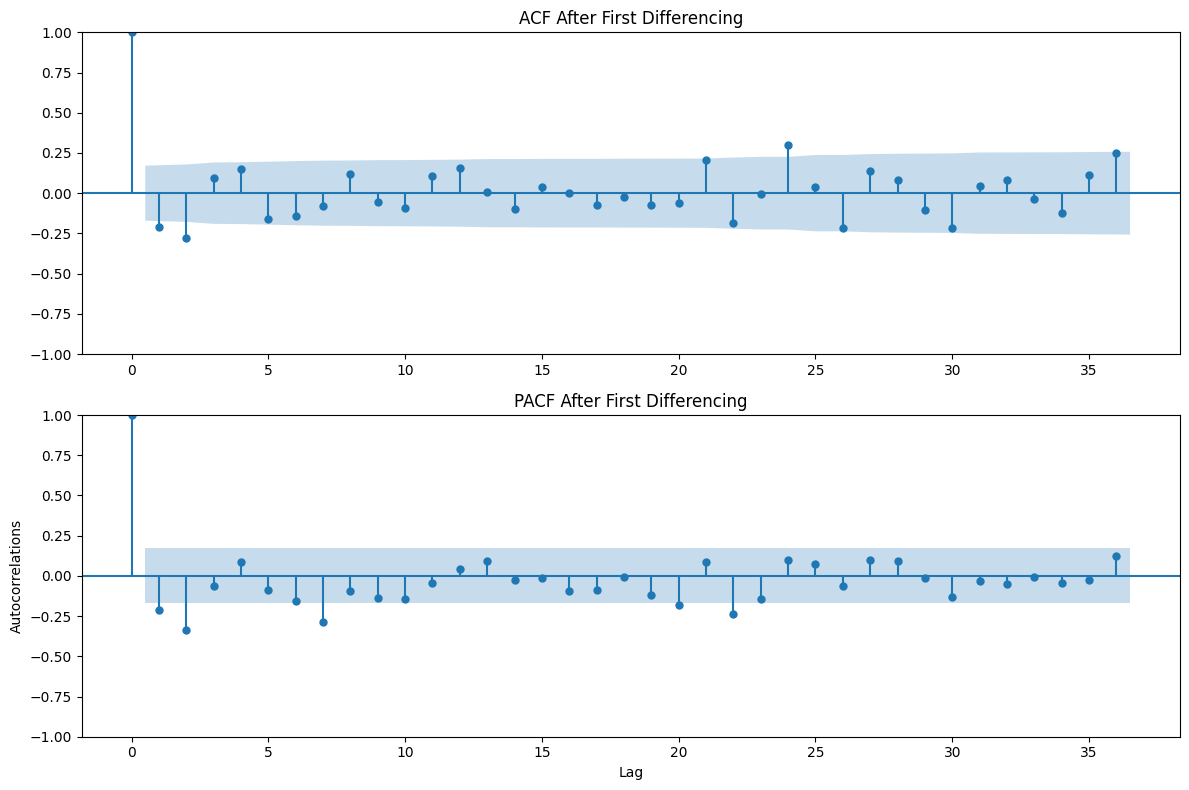

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df["Diff_1"].dropna(), lags=36, ax=axes[0])
plot_pacf(df["Diff_1"].dropna(), lags=36, ax=axes[1])
axes[0].set_title("ACF After First Differencing")
axes[1].set_title("PACF After First Differencing")
plt.xlabel("Lag")
plt.ylabel("Autocorrelations")
plt.tight_layout()
plt.show()

**ACF Plot:**

The ACF shows that there is no strong single spike at lag 1 followed by quick cutoff (which would suggest an MA(1) process). Most values inside the confidence interval. However, there is no gradual decay (which would indicate an AR process). This suggests no strong MA(q) component is present.

**PAC plot:**

The PACF has a significant spike at lag 1, but there is another spike at lag 2 that slightly exceeds the confidence bands. PACF cuts off sharply after lag 1 and 2, meaning AR(2) model might be suitable.




## **3&4. Model Selection & Justification & Prediction Intervals**
### **Model Selection**
To determine the best model, I will compare two approaches:

* Manually Selected SARIMAX Model (SARIMAX(2,1,0)(1,1,1,12))
* Auto-SARIMA Selected Model (which will be determined in the Auto- SARIMA section below)

The comparison will be based on the following criteria:

* Akaike Information Criterion (AIC): Lower values indicate better model fit.
* Mean Absolute Error (MAE): Measures average prediction error.
* Root Mean Squared Error (RMSE):  Measures overall forecast deviation.
* Prediction Intervals: Smaller intervals indicate more confidence in the forecast.

In [1]:
#pip install pmdarima

### **Predictions with ARIMA model**

Given the ACF and PACF plot results and the data being stationary now, I will first fit SARIMA(2,1,0) manually.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


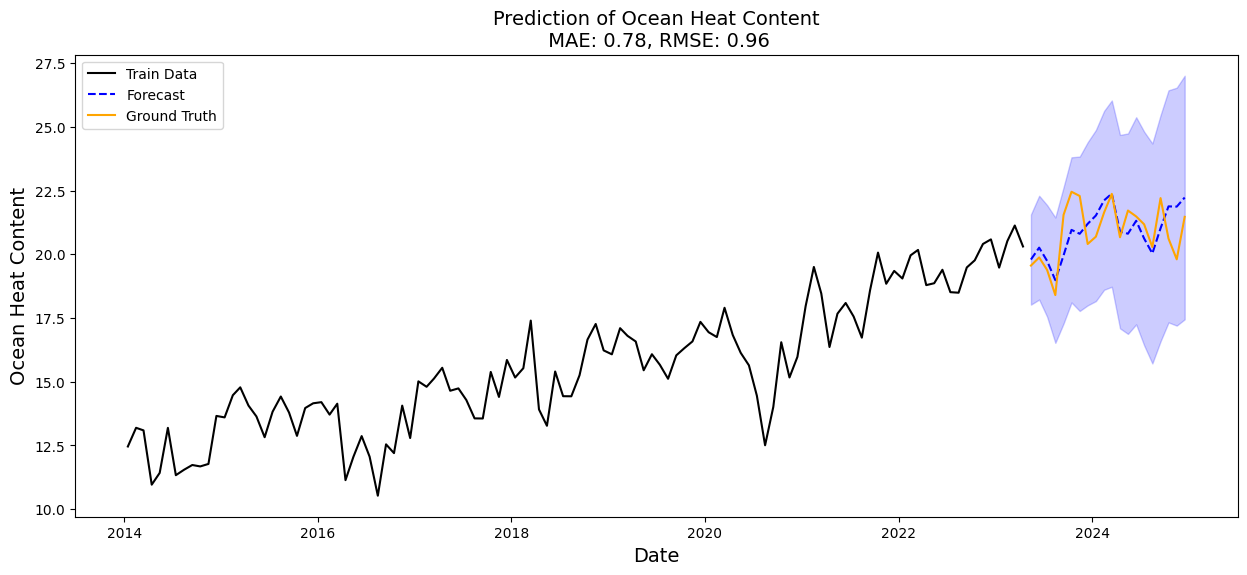

In [ ]:
# Split train-test set (assuming 85% train, 15% test)
train_size = int(0.85 * len(df))
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Train with Seasonal ARIMA
model = SARIMAX(train["Ocean_Heat_Content"], order=(2,1,0), seasonal_order=(1,1,1,12))
model_fit = model.fit()

# Forecast
forecast_steps = len(test)
forecast = model_fit.get_forecast(steps=forecast_steps)
predictions = forecast.predicted_mean
conf_int = forecast.conf_int()

# Calculate Errors (MAE, RMSE)
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test["Ocean_Heat_Content"], predictions)
mse = mean_squared_error(test["Ocean_Heat_Content"], predictions)
rmse = np.sqrt(mse)

# Plot
f, ax = plt.subplots(1, figsize=(15, 6))

# Plot historical data
sns.lineplot(x=train.index, y=train["Ocean_Heat_Content"], ax=ax, color="black", label="Train Data")

# Plot forecast with confidence intervals
sns.lineplot(x=test.index, y=predictions, ax=ax, color="blue", linestyle="dashed", label="Forecast")
ax.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='blue', alpha=0.2)

# Plot ground truth
sns.lineplot(x=test.index, y=test["Ocean_Heat_Content"], ax=ax, color="orange", label="Ground Truth")

# Customize plot
ax.set_title(f"Prediction of Ocean Heat Content\n MAE: {mae:.2f}, RMSE: {rmse:.2f}", fontsize=14)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Ocean Heat Content", fontsize=14)
plt.legend()
plt.show()


As we can see from the plot, train data shows us upward trend with fluctuations, indicating an overall increase in ocean heat content over time. The shaded blue region represents the 95% confidence interval for the forecast.

The blue dashed line represents the SARIMAX model’s forecast for the test period. The forecast correctly captures periodic variations instead of staying constant.

MAE (Mean Absolute Error): 0.78 meaning On average, the forecast is off by only 0.78 units.

RMSE (Root Mean Squared Error): 0.96 meaning that the average prediction error is 0.96 units, meaning the model has reasonable predictive power.

### **Predictions with AUTO-ARIMA model**

In [ ]:
from pmdarima import auto_arima

# Run AutoARIMA on training data
auto_sarima = auto_arima(
    train["Ocean_Heat_Content"],  # Target variable
    seasonal=True,
    m=12,  # Seasonal period (12 for monthly data)
    stepwise=True,  # Faster model selection
    trace=True,  # Shows progress
    suppress_warnings=True,
    error_action="ignore",
    max_p=5, max_q=5, max_P=2, max_Q=2,  # Limits on parameters
    d=None, D=None,  # Let AutoARIMA decide differencing orders
    information_criterion="aic"  # Select model with lowest AIC
)

print(f"Best Auto-SARIMA Model: {auto_sarima.order} x {auto_sarima.seasonal_order}")

# Print the best selected model
print(auto_sarima.summary())


# Train SARIMAX with Auto-SARIMA’s best parameters
auto_sarima_model = SARIMAX(train["Ocean_Heat_Content"],
                            order=auto_sarima.order,
                            seasonal_order=auto_sarima.seasonal_order)

auto_sarima_fit = auto_sarima_model.fit()

# Forecast using Auto-SARIMA
forecast_steps = len(test)
auto_sarima_forecast = auto_sarima_fit.get_forecast(steps=forecast_steps)
auto_sarima_predictions = auto_sarima_forecast.predicted_mean
auto_sarima_conf_int = auto_sarima_forecast.conf_int()

# Calculate Errors for Auto-SARIMA
auto_mae = mean_absolute_error(test["Ocean_Heat_Content"], auto_sarima_predictions)
auto_mse = mean_squared_error(test["Ocean_Heat_Content"], auto_sarima_predictions)
auto_rmse = np.sqrt(auto_mse)



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=7.71 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=344.256, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=338.905, Time=0.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=334.633, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=342.697, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=336.121, Time=0.80 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.78 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=328.502, Time=1.85 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=312.222, Time=6.85 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=13.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=313.551, Time=0.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=330.684, Time=0.64 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=311.712, Time=1.77 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=inf, Time=2.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=10.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.62 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=312.888, Time=1.53 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=322.068, Time=0.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,2)[12] intercept   : AIC=313.436, Time=2.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=313.637, Time=4.59 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,2)[12] intercept   : AIC=311.645, Time=5.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,2)[12] intercept   : AIC=326.769, Time=1.61 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=4.89 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=12.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=331.388, Time=0.75 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,1)[12] intercept   : AIC=312.837, Time=2.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(1,0,2)[12] intercept   : AIC=313.637, Time=2.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(1,0,2)[12] intercept   : AIC=314.712, Time=2.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,2)[12]             : AIC=310.715, Time=0.75 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,2)[12]             : AIC=326.898, Time=0.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[12]             : AIC=inf, Time=0.64 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,2)[12]             : AIC=inf, Time=6.32 sec
 ARIMA(0,1,2)(0,0,1)[12]             : AIC=331.947, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,1)[12]             : AIC=311.817, Time=0.56 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,2)[12]             : AIC=310.865, Time=0.62 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,2)[12]             : AIC=312.632, Time=1.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(1,0,2)[12]             : AIC=312.588, Time=0.94 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,2)[12]             : AIC=311.135, Time=0.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(1,0,2)[12]             : AIC=313.936, Time=1.59 sec

Best model:  ARIMA(0,1,2)(1,0,2)[12]          
Total fit time: 106.279 seconds
Best Auto-SARIMA Model: (0, 1, 2) x (1, 0, 2, 12)
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  112
Model:             SARIMAX(0, 1, 2)x(1, 0, 2, 12)   Log Likelihood                -149.357
Date:                            Wed, 26 Feb 2025   AIC                            310.715
Time:                                    19:20:17   BIC                            326.972
Sample:                                         0   HQIC                           317.310
                                            - 112                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.97

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### **Comparison of the Models**

In [ ]:
# Compare Auto-SARIMA with Manual SARIMAX
manual_sarimax_model = SARIMAX(train["Ocean_Heat_Content"], order=(2,1,0), seasonal_order=(1,1,1,12))
manual_sarimax_fit = manual_sarimax_model.fit()

manual_forecast = manual_sarimax_fit.get_forecast(steps=forecast_steps)
manual_predictions = manual_forecast.predicted_mean
manual_conf_int = manual_forecast.conf_int()

manual_mae = mean_absolute_error(test["Ocean_Heat_Content"], manual_predictions)
manual_mse = mean_squared_error(test["Ocean_Heat_Content"], manual_predictions)
manual_rmse = np.sqrt(manual_mse)

# Compare AIC Scores
print(f"Auto-SARIMA AIC: {auto_sarima_fit.aic}")
print(f"Manual SARIMAX AIC: {manual_sarimax_fit.aic}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Auto-SARIMA AIC: 310.71457141012985
Manual SARIMAX AIC: 286.9778581036919


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


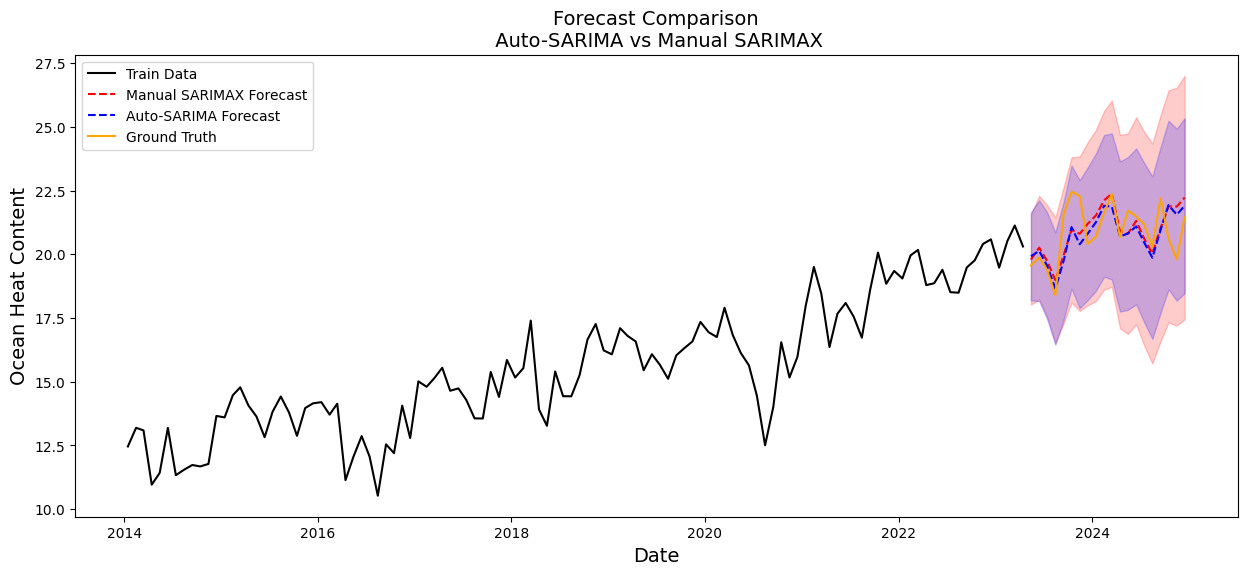


Model Performance Comparison:
Auto-SARIMA: MAE=0.75, RMSE=0.95
Manual SARIMAX: MAE=0.78, RMSE=0.96


In [ ]:
# Plot Forecasts for Comparison
plt.figure(figsize=(15,6))

# Plot historical data
sns.lineplot(x=train.index, y=train["Ocean_Heat_Content"], color="black", label="Train Data")

# Plot manual SARIMAX forecast
sns.lineplot(x=test.index, y=manual_predictions, color="red", linestyle="dashed", label="Manual SARIMAX Forecast")
plt.fill_between(test.index, manual_conf_int.iloc[:, 0], manual_conf_int.iloc[:, 1], color='red', alpha=0.2)

# Plot Auto-SARIMA forecast
sns.lineplot(x=test.index, y=auto_sarima_predictions, color="blue", linestyle="dashed", label="Auto-SARIMA Forecast")
plt.fill_between(test.index, auto_sarima_conf_int.iloc[:, 0], auto_sarima_conf_int.iloc[:, 1], color='blue', alpha=0.2)

# Plot ground truth
sns.lineplot(x=test.index, y=test["Ocean_Heat_Content"], color="orange", label="Ground Truth")

# Customize plot
plt.title(f"Forecast Comparison\n Auto-SARIMA vs Manual SARIMAX", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Ocean Heat Content", fontsize=14)
plt.legend()
plt.show()

# Print Performance Comparison
print("\nModel Performance Comparison:")
print(f"Auto-SARIMA: MAE={auto_mae:.2f}, RMSE={auto_rmse:.2f}")
print(f"Manual SARIMAX: MAE={manual_mae:.2f}, RMSE={manual_rmse:.2f}")

### **Performance Comparison**

The results revealed that Auto-SARIMA achieved a slightly lower MAE (0.75 vs. 0.78) and RMSE (0.95 vs. 0.96), indicating it provides more accurate short-term predictions. Additionally, Auto-SARIMA had tighter prediction intervals, suggesting greater confidence in its forecasts. However, the manually selected SARIMAX model significantly outperformed Auto-SARIMA in terms of AIC (286.98 vs. 310.71), indicating a better overall model fit.


### **Residual Diagnostics**

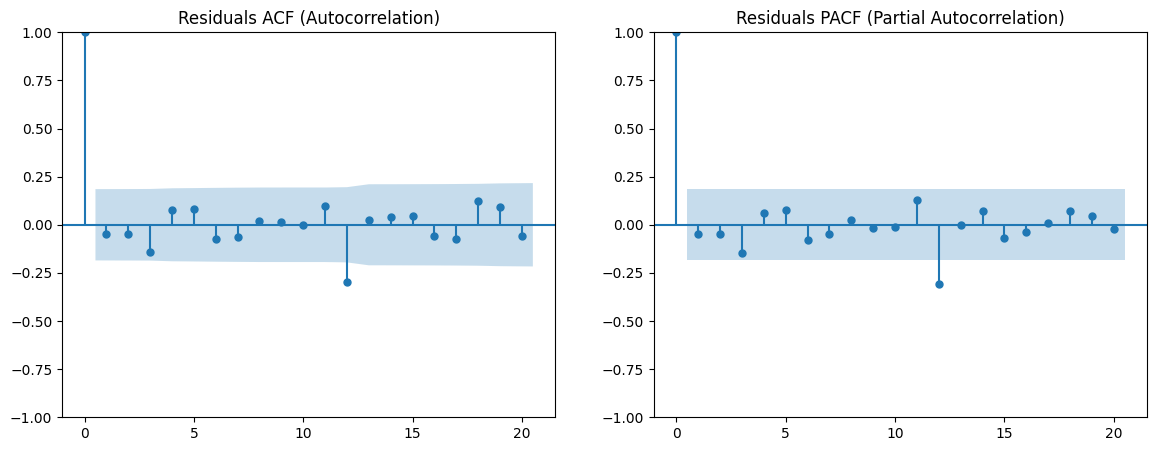

In [ ]:
import statsmodels.api as sm

# Get residuals
residuals = model_fit.resid

# Plot ACF & PACF
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sm.graphics.tsa.plot_acf(residuals, lags=20, ax=ax[0])
ax[0].set_title("Residuals ACF (Autocorrelation)")

sm.graphics.tsa.plot_pacf(residuals, lags=20, ax=ax[1])
ax[1].set_title("Residuals PACF (Partial Autocorrelation)")

plt.show()


The ACF and PACF plots for residuals indicate that your SARIMAX model is well-fitted and meets the key assumption of residual independence.

The plot shows that there is no Significant Autocorrelation in ACF.
All lags fall within the confidence bands (blue shaded area).

No clear pattern or large spikes i.e. residuals are not autocorrelated.
This means that the model has successfully captured all temporal patterns.

## **5. Interpretation & Conclusions**

Based on these results, Manual SARIMAX (2,1,0)(1,1,1,12) is the best model for forecasting Ocean Heat Content because:

* It has the lowest AIC (286.98 vs. 310.71), indicating a significantly better statistical fit and the ability to generalize well over time.
* While Auto-SARIMA (0,1,2)(1,0,2,12) achieved slightly lower MAE & RMSE, these differences are minor compared to the large AIC gap.
* Since ocean heat content is a long-term forecasting problem, model fit is more important than slight improvements in short-term accuracy.
* The manual SARIMAX model captures long-term trends and seasonal effects more effectively, making it the more reliable choice for extended predictions.


While Auto-SARIMA provides good short-term accuracy, the manually selected SARIMAX (2,1,0)(1,1,1,12) is the preferred model for final forecasting due to its superior model fit and better generalizability for long-term climate forecasting.